## Demo
We have the file below to demostrate how to use the SAM model and use the fine tuned model to help extract the segmentation part fro whole Imge

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/17J9zvbiEA5klJnTdmsBVaPk1jlZhIhR4?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

# SAM Set up section

To access your google drive, run the section below to connect the Colab to your google drive. Then you session will be able to access to your drive on the left side. 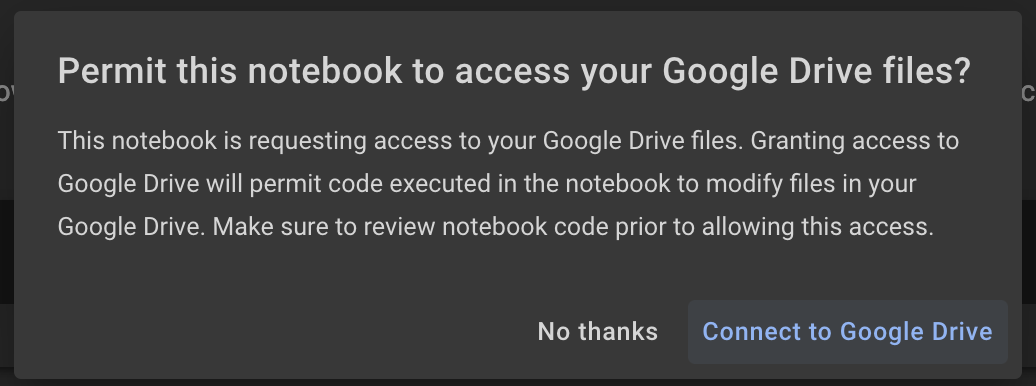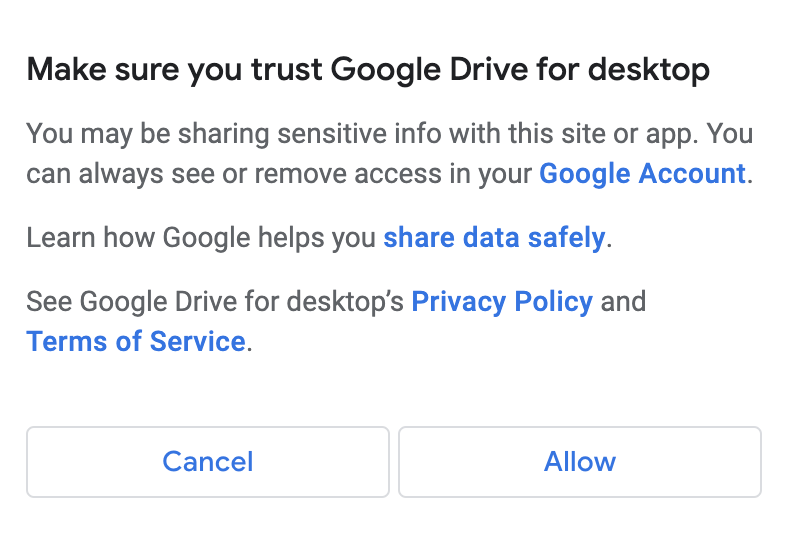

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will be able to find yout file path on the left side of coding section like shown below in the picture

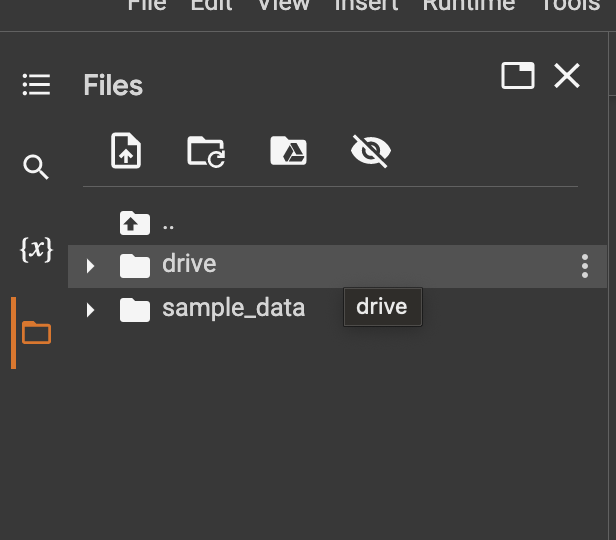

Install all the packages required

In [5]:
!pip install segment_anything
!pip install supervision
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install collections
!pip install opencv-python


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all the packages required for the code running below

In [6]:
import numpy as np
import matplotlib
from segment_anything import SamPredictor, sam_model_registry
import torch
from segment_anything.utils.transforms import ResizeLongestSide
from collections import defaultdict
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import supervision as sv
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

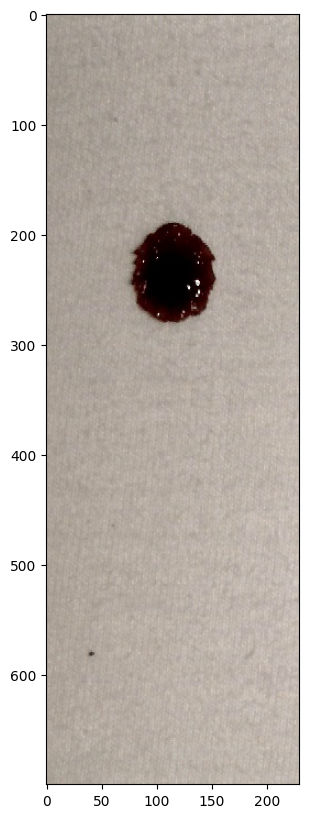

In [ ]:
# Impot a new image that the model hasn't seen before:
image_org = cv2.imread(f'/content/drive/MyDrive/img012.jpg')
image = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Single Image Processing Function.

In this secion you can import the model from your google drive and run the code online to save all computational power.

In [ ]:
model_type = 'vit_b'
checkpoint = '/content/drive/MyDrive/tuned_model.pth' # here should be te path to the sam model you have or the fine tuned model you would like to use. model provided in the github as well.
device = 'cuda:0'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

# Set up predictors for both tuned models
predictor_tuned = SamPredictor(sam_model)

Prompt: When Box is provided in the image as a prompt for mask area selection.

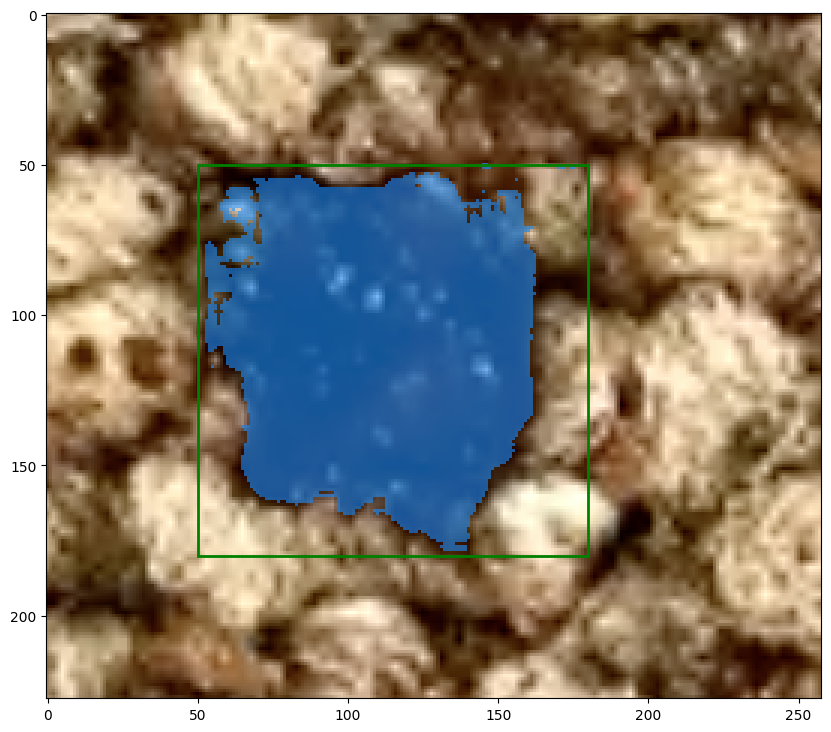

In [ ]:
input_box = np.array([50, 50, 180, 180])

predictor_tuned.set_image(image)

masks_tuned,_, _= predictor_tuned.predict(
    #point_coords=input_point,
    #point_labels=input_label,
    #point_coords=None,
    #point_labels=None,
    box=input_box[None,:],
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks_tuned[0], plt.gca())
#show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

Prompt point: you can also use point as a prompt for your image to selecte particular points or include certain droplets.

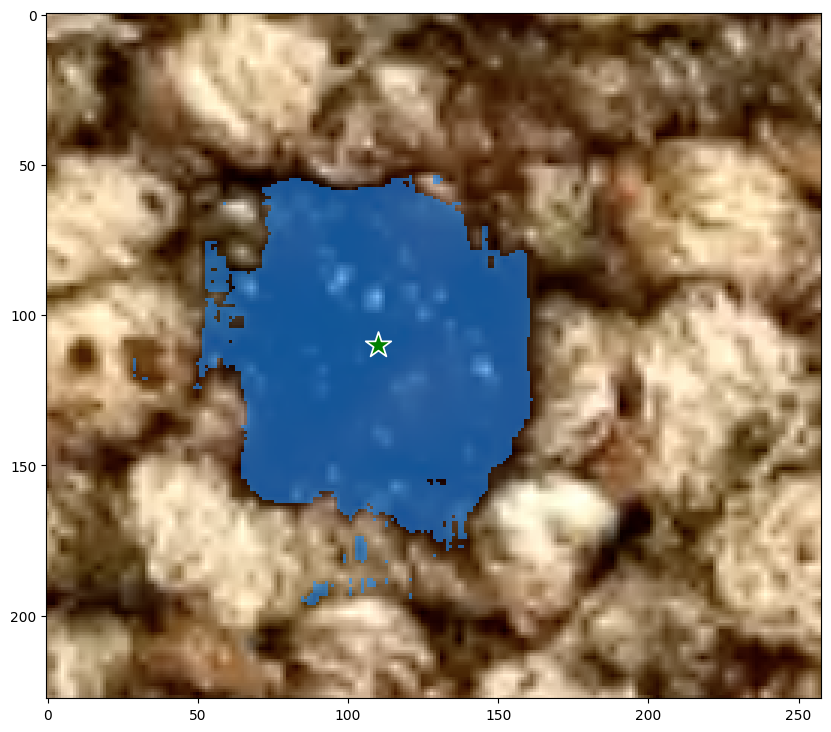

In [ ]:
input_point = np.array([[110, 110]])
input_label = np.array([1])

predictor_tuned.set_image(image)

masks_tuned,_, _= predictor_tuned.predict(
    point_coords=input_point,
    point_labels=input_label,
    # box=input_box[None,:],
    multimask_output= False, # Change here to True if you would like to have mutiple layers of masks.
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks_tuned[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Run the SAM model with Auto method. You don't need to change anything, the parameters can be adjusted bassed on your requirement.

In [ ]:
# Set up predictors for both tuned and original models
mask_generator_tuned = SamAutomaticMaskGenerator(sam_model,
                                                 crop_n_layers=1,
                                                 points_per_side=2,
                                                 pred_iou_thresh=0.2,
                                                 stability_score_thresh=0.8,
                                                 crop_n_points_downscale_factor=1,
                                                 min_mask_region_area=100,
                                                 )
masks_tuned = mask_generator_tuned.generate(image)

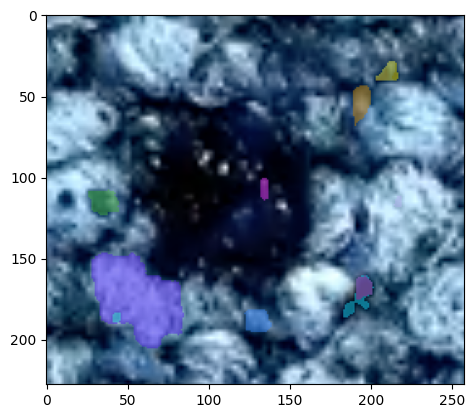

In [ ]:
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks_tuned)
annotated_image = mask_annotator.annotate(image_org, detections)
plt.imshow(annotated_image)

## Many Images processing
In this section, you can put many images here to make the image processing running and processes many images in one time with a unifed prompt.

In [ ]:
import os

##Defult model for images


input_point = np.array([[115, 350]]) # You can use the prompt for box and point at the same time or you can change it based on the code example above.
input_label = np.array([1])
## With Prompt


model_type = 'vit_b'
checkpoint = '/content/drive/MyDrive/sam_vit_b_01ec64.pth' # Change this to the model you would like to use.
device = 'cuda:0' # run this model on GPU, set it to 'cpu' to run model on CPU, which may cause the running time longer

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
loss_fn = torch.nn.MSELoss()



predictor_tuned.set_image(image)

## Automatic
mask_generator = SamAutomaticMaskGenerator(sam_model)


folder_path = '/content/drive/MyDrive/' #Change this to the address you saved your image datasets
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')]) # if the image you have is in the .jpg file type.

for image_file in image_files:
    box_image_name = os.path.splitext(image_file)[0] + "_box.jpg"
    box_image_path = "/content/drive/MyDrive/RGB_result/" + box_image_name #remember to change the address to the address you would like to save the images

    point_image_name = os.path.splitext(image_file)[0] + "_point.jpg"
    point_image_path = "/content/drive/MyDrive/Blooddrop/RGB_result/" + point_image_name #remember to change the address to the address you would like to save the images

    auto_image_name = os.path.splitext(image_file)[0] + "_auto.jpg"
    auto_image_path = "/content/drive/MyDrive/Blooddrop/RGB_result/" + auto_image_name #remember to change the address to the address you would like to save the images


    image_path = os.path.join(folder_path, image_file)
    image_org = cv2.imread(image_path)
    image = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
    ## predict image
    predictor_tuned.set_image(image)


    ## mask generation with box
    input_box = np.array([0, 0, 230, 700])

    predictor.set_image(image)

    masks,_, _= predictor.predict(
      #point_coords=input_point,
      #point_labels=input_label,
      #point_coords=None,
      #point_labels=None,
      box=input_box[None,:],
      multimask_output=False,
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    #show_points(input_point, input_label, plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.savefig(box_image_path)
    plt.show()



    ## mask generation with points
    masks_tuned,_, _= predictor_tuned.predict(
      point_coords=input_point,
      point_labels=input_label,
      # box=input_box[None,:],
      multimask_output= False,
    )
    ## Save plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    plt.savefig(point_image_path)
    plt.show()


    ## Automatic
    masks = mask_generator.generate(image)
    mask_annotator = sv.MaskAnnotator()
    detections = sv.Detections.from_sam(masks)
    annotated_image = mask_annotator.annotate(image_org, detections)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(annotated_image)
    plt.savefig(auto_image_path)





This section show the function about how can you import the images dataset from the numpy arrays

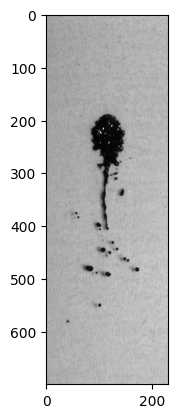

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the array of images from numpy file
Images = np.load("/content/drive/MyDrive/Zihan_DK_Lab/Project_2_CV_Crimiology/Blooddrop/New_Videos/Additional_images.npy")


# Display the 12th image
plt.imshow(Images[12])
plt.show()
